In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # removal rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 0.1          # rate Is -> Q, fast testing for the infected 



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])
A0  = np.array([20, 20])
Ia0 = np.array([10, 10])     
Is0 = np.array([10, 10])     
Q0  = np.array([10, 10])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAIRQ_latent_traj.npy', data_array)

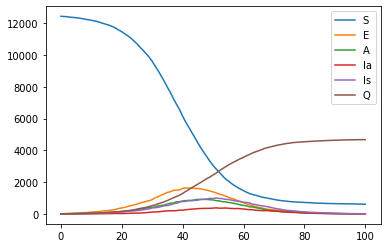

In [4]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
plt.plot(data_array[:, 5*M], label='Q')

plt.legend()
plt.show()

# Infer parameters based on part of the trajectory

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SEAIRQ_latent_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number internal integration steps taken



# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, False, False, True, True]), M)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-946.6759173203372
1.118016004562378


In [6]:
alpha_g = 0.3          ## bad initial guess
alpha_std = 0.2 
alpha_b = (0.1,0.9)

beta_g  = 0.05         ## bad initial guess
beta_std = 0.1 
beta_b = (1e-3, 1)

gIa_g   = 0.13   
gIa_std = 0.1 
gIa_b = (0.01, 1)

gIs_g   = 0.12 
gIs_std = 0.1 
gIs_b = (0.01, 1)

gE_g    = 0.2
gE_std = 0.1
gE_b = (0.01, 1)

gA_g    = 0.3 
gA_std = 0.1 
gA_b = (0.01, 1) 
   

E0_g = (E0+2)/N 
E_std = E0_g*0.4 
bounds_for_E = np.tile([0.1/N, 100/N], M).reshape(M, 2)

A0_g = (A0+2)/N 
A_std = A0_g*0.4 
bounds_for_A = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ia0_g = (Ia0-2)/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Is0_g = (Is0+1)/N 
Is_std = Is0_g*0.2 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Q0_g = (Q0+1)/N 
Q_std = Q0_g*0.2
bounds_for_Q = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0-10)/N
S_std = Ia_std*np.sqrt(5)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)


# optimisation parameters 
eps = 1e-4 
ftol = 1e-4 # the relative tol in (-logp)  

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, 
                   *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Q])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, 
                  *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Q0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std, 
                 *S_std, *E_std, *A_std, *Ia_std, *Is_std, *Q_std])
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                   global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol, eps=eps) 
# the L-BFGS-B method prints to the terminal rather than here 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 18 (seed=1064367, Thu May  7 22:58:59 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -9.980223914213464e+02 1.0e+00 9.23e-01  4e-04  2e-01 0:06.7
    2     32 -9.967131434454076e+02 1.1e+00 8.82e-01  4e-04  2e-01 0:12.8
    3     48 -1.009534618342918e+03 1.1e+00 9.07e-01  4e-04  2e-01 0:18.6
    4     64 -1.019193184245843e+03 1.2e+00 9.14e-01  4e-04  2e-01 0:23.5
    5     80 -8.584553262005332e+02 1.3e+00 9.35e-01  4e-04  2e-01 0:28.8
    6     96 -9.070232666788829e+02 1.3e+00 9.27e-01  4e-04  2e-01 0:34.5
    7    112 -9.365322118234833e+02 1.4e+00 9.26e-01  4e-04  2e-01 0:40.9
    9    144 -8.621160077130057e+02 1.5e+00 9.44e-01  4e-04  2e-01 0:51.9
   11    176 -1.010107742045888e+03 1.5e+00 8.89e-01  4e-04  2e-01 1:02.7
   13    208 -9.771152805945297e+02 1.5e+00 8.11e-01  3e-04  2e-01 1:13.3
Optimal value (global minimisation):  -1019.1931842458433
Start

In [7]:
np.save('latent_SEAIRQ_params.npy', params)

In [8]:
params = np.load('latent_SEAIRQ_params.npy')
print('best estimates for params: ', params[:6])
print('best estimates for initial conditions: ', params[6:])

best estimates for params:  [0.18689292 0.0240408  0.03638093 0.19929736 0.15587195 0.48188366]
best estimates for initial conditions:  [2.48388590e-01 7.48385325e-01 3.68936588e-04 4.59874700e-04
 6.12509237e-04 3.86529718e-04 1.86328574e-04 1.61516648e-04
 1.97435545e-04 1.90110281e-04 2.02676479e-04 2.01658691e-04]


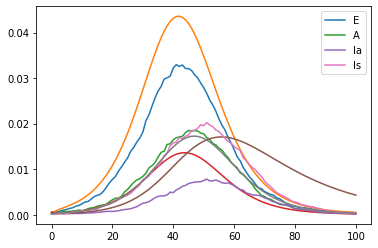

In [9]:
parameters = estimator.make_params_dict(params)
estimator.set_params(parameters)
x0 = params[6:]
det_model = pyross.deterministic.SEAIRQ(parameters, int(M), fi)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)


x_full = np.load('SEAIRQ_latent_traj.npy')/N
plt.plot(x_full[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x_full[:,2*M], label='A')
plt.plot(x_det[:, 2*M])
plt.plot(x_full[:,3*M], label='Ia')
plt.plot(x_det[:, 3*M])
plt.plot(x_full[:,4*M], label='Is')
plt.plot(x_det[:, 4*M])
# plt.plot(x_full[:,5*M], label='Q')
# plt.plot(x_det[:, 5*M])
plt.legend()
plt.show()

**Warning: For latent forecasting, the resulting Hessian is sometimes not positive definite. This is a known issue that is being worked on.**

In [10]:
hess_params, hess_init = estimator.hessian_latent(params, guess, stds, obs[1:], fltr, 
                                                  Tf_inference, Nf_inference, contactMatrix, 
                                                  beta_rescale=4, eps=1e-4)

In [11]:
np.save('SEAIRQ_hess_params.npy', hess_params)
np.save('SEAIRQ_hess_init.npy', hess_init)

In [12]:
hess_params = np.load('SEAIRQ_hess_params.npy')
hess_init = np.load('SEAIRQ_hess_init.npy')
cov_params = np.linalg.inv(hess_params)
cov_init = np.linalg.inv(hess_init)

# Compare forecast based on inferred parameters to full trajectory

In [13]:
parameters = {'alpha':params[0], 'beta':params[1],
              'gIa':params[2], 'gIs':params[3],
              'gE':params[4],'gA':params[5],
            'S0':params[6: 6+M],
            'E0':params[6+M:6+2*M],
            'A0':params[6+2*M:6+3*M],
            'Ia0':params[6+3*M:6+4*M],
            'Is0':params[6+4*M:6+5*M],
            'Q0':params[6+5*M:6+6*M],
               'fsa':fsa,
             'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs,
             'cov_init':cov_init, 'cov_params':cov_params
             }

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAIRQ_latent(parameters, M, Ni)

In [14]:
# Number of simulations over which we average, use 500
Ns = 10 

Tf_forecast = Tf #- Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                          method='tau-leaping',
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] #+ Tf_inference

/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


Finished. Time needed for evaluation: 00:06:34


**Warning: For latent forecasting, the resulting Hessian is sometimes not positive definite. This is a known issue that is being worked on.**

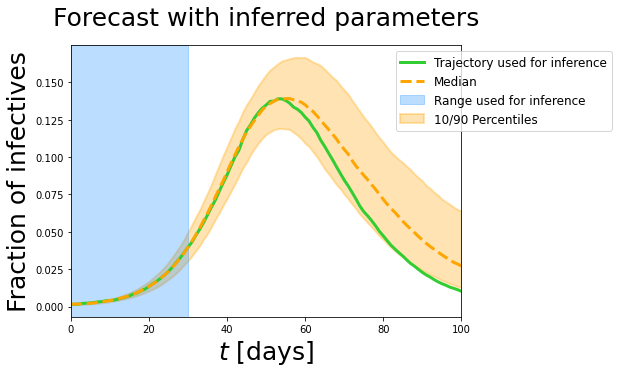

In [15]:
# Plot sum of A, Ia, Is populations

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


data_array = np.load('SEAIRQ_latent_traj.npy')
cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)

ax.fill_between(t_forecast,percentiles_lower/N,
        percentiles_upper/N,
                alpha=0.3,
        lw=2,
        label=r'10/90 Percentiles',
        color='orange',
       )

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show()
#fig.savefig('inference_and_forecasting_SEAIRQ.png',bbox_inches='tight',dpi=100)
plt.close()

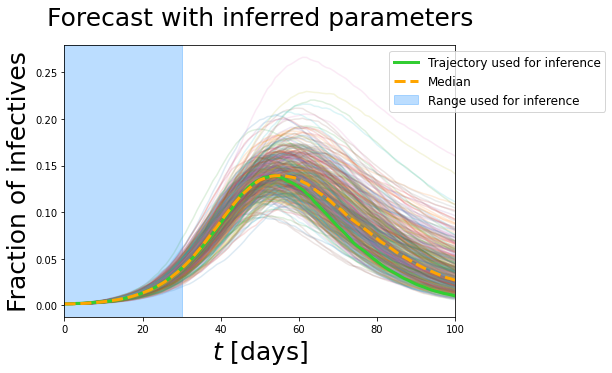

In [16]:
# plot all trajectories 
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


data_array = np.load('SEAIRQ_latent_traj.npy')
cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show()
#fig.savefig('inference_and_forecasting_SEAIRQ.png',bbox_inches='tight',dpi=100)
plt.close()